In [1]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats

# Punto 2

In [2]:
infty = math.inf

#Costo amortizado
C1, C2, C3 = 3.7,3.8,4
C = np.array([C1,C2,C3])
Q_EXTRA = 15

# suma de 
C_MAX = 8000 

#Costo operación diaria
Q1, Q2, Q3 = 2.7,2.6,2.5

#Costo importacion de energia


# DEMANDA ALTA MEDIA Y BAJA

DEMANDA_ALTA = 300
DEMANDA_MEDIA = 250
DEMANDA_BAJA = 200


# posibles xi
K = 100

# posibles parametros de incertidumbre

capacidades_gen1 = stats.beta.rvs(8,2,size=K)
capacidades_gen2 = stats.beta.rvs(8,2,size=K)
capacidades_gen3 = stats.beta.rvs(8,2,size=K)

demandas_altas = stats.uniform.rvs(DEMANDA_ALTA, scale = DEMANDA_ALTA*0.2 ,size= K)
demandas_medias = stats.uniform.rvs(DEMANDA_MEDIA, scale = DEMANDA_MEDIA*0.2 ,size= K)
demandas_bajas = stats.uniform.rvs(DEMANDA_BAJA, scale = DEMANDA_BAJA*0.2 ,size= K)


#probabilidad de tomar alguna realización

prob = 1/K

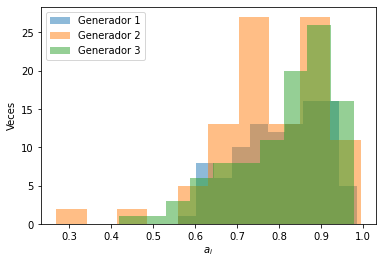

In [29]:
plt.hist(capacidades_gen1,alpha=0.5, label='Generador 1')
plt.hist(capacidades_gen2,alpha=0.5,  label='Generador 2')
plt.hist(capacidades_gen3,alpha=0.5,  label='Generador 3')
plt.xlabel(r'$a_i$')
plt.ylabel('Veces')
plt.legend()


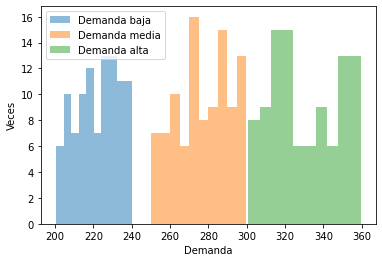

In [31]:
plt.hist(demandas_bajas,alpha=0.5, label='Demanda baja')
plt.hist(demandas_medias,alpha=0.5,  label='Demanda media')
plt.hist(demandas_altas,alpha=0.5,  label='Demanda alta')
plt.xlabel('Demanda')
plt.ylabel('Veces')
plt.legend()


# Punto 3

## L-Shaped

In [4]:
#PASO 2 
#NO SE USA!!


def feasibility_cut(xvs):
    
    xv = xvs
    
    D = np.zeros(3)
    d = 0
    
    for realiz in range(K):
        capacidad_gen1 = capacidades_gen1[realiz]
        capacidad_gen2 = capacidades_gen2[realiz]
        capacidad_gen3 = capacidades_gen3[realiz]
        demanda_alta = demandas_altas[realiz]
        demanda_media = demandas_medias[realiz]
        demanda_baja = demandas_bajas[realiz]
    
        problema_feasibility = Model("feasibility")
        problema_feasibility.setParam('OutputFlag', 0)

        y = problema_feasibility.addMVar(shape=21, lb=0.0, vtype = GRB.CONTINUOUS, name='y')
        vmas = problema_feasibility.addMVar(shape=12, lb=0.0, vtype = GRB.CONTINUOUS, name='v+')
        vmenos = problema_feasibility.addMVar(shape=12, lb=0.0, vtype = GRB.CONTINUOUS, name='v-')

        W = np.zeros((12,21))
        for i in range(9):
            W[i,i]=1
            W[i,i+9]=1

        W[9:12, 0:3] = np.eye(3)
        W[9:12, 3:6] = np.eye(3)
        W[9:12, 6:9] = np.eye(3)
        W[9:12, 18:21] = np.eye(3)

        T = np.zeros((12,3))
        T[0:3,0] = -capacidad_gen1*np.ones(3)
        T[3:6,1] = -capacidad_gen2*np.ones(3)
        T[6:9,2] = -capacidad_gen3*np.ones(3)

        h = np.zeros(12)
        h[9:12]= [demanda_baja, demanda_media, demanda_alta]


        problema_feasibility.setObjective(vmas.sum()+vmenos.sum(), GRB.MINIMIZE)

        constr = problema_feasibility.addConstr(W@y + np.eye(12)@vmas + np.eye(12)@vmenos == h.T - T@xv.T, "restric" )

        problema_feasibility.optimize();

        if problema_feasibility.objVal>0:
            print('ERROR NO SIRVE EL ESCLAVO')



In [5]:
#PASO 3
def problema_esclavo(xvs):
    
    xv = xvs
    
    E = np.zeros(3)
    e = 0

    
    for realiz in range(K):
        capacidad_gen1 = capacidades_gen1[realiz]
        capacidad_gen2 = capacidades_gen2[realiz]
        capacidad_gen3 = capacidades_gen3[realiz]
        demanda_alta = demandas_altas[realiz]
        demanda_media = demandas_medias[realiz]
        demanda_baja = demandas_bajas[realiz]

        problema_esclavo = Model("esclavo")
        problema_esclavo.setParam('OutputFlag', 0)

        y = problema_esclavo.addMVar(shape=21, lb=0.0, vtype = GRB.CONTINUOUS, name='y')

        W = np.zeros((12,21))
        for i in range(9):
            W[i,i]=1
            W[i,i+9]=1

        W[9:12, 0:3] = np.eye(3)
        W[9:12, 3:6] = np.eye(3)
        W[9:12, 6:9] = np.eye(3)
        W[9:12, 18:21] = np.eye(3)

        T = np.zeros((12,3))
        T[0:3,0] = -capacidad_gen1*np.ones(3)
        T[3:6,1] = -capacidad_gen2*np.ones(3)
        T[6:9,2] = -capacidad_gen3*np.ones(3)

        h = np.zeros(12)
        h[9:12]= [demanda_baja, demanda_media, demanda_alta]


        problema_esclavo.setObjective(Q1*(y[0]+y[1]+y[2]) + Q2*(y[3]+y[4]+y[5]) + Q3*(y[6]+y[7]+y[8]) + Q_EXTRA*(y[18]+y[19]+y[20]), GRB.MINIMIZE)

        constr = problema_esclavo.addConstr(W@y + T@xv.T == h.T, "restric" )

        problema_esclavo.optimize();

        PI_k = constr.PI
        E += PI_k @ T
        e += PI_k @ h

    E = prob*E
    e = prob*e
    w = e-E@xv
    return E,e,w

In [6]:
#PASO 0
r,s,v = 0, 0, 0

solucion = 0
Es = []
es = []
thetaIncluir = 0
while solucion==0:
    
    #PASO 1 PROBLEMA MAESTRO
    v+=1
    
    problema_maestro = Model("maestro")
    problema_maestro.setParam('OutputFlag', 0)
    x = problema_maestro.addMVar(shape = 3, lb=0.0, vtype = GRB.CONTINUOUS, name = 'x')
    s1 = problema_maestro.addMVar(shape= 1, lb=0.0, vtype = GRB.CONTINUOUS, name = 's1')

    
    if len(Es)==0:
        theta = -infty
        problema_maestro.setObjective(C@x, GRB.MINIMIZE)
    else:
        thetaIncluir = 1
        theta = problema_maestro.addMVar(shape= 1, lb=0.0, vtype = GRB.CONTINUOUS, name = 'theta')
        problema_maestro.setObjective(C@x + theta, GRB.MINIMIZE)

    ##Ax=b
    constr = problema_maestro.addConstr(C@x + s1 == C_MAX, "costo_máximo" )
    
    for i in range(s):
        problema_maestro.addConstr(Es[i]@x + theta >= es[i]  ,"optimality_cut{}".format(i) )

    problema_maestro.optimize()

    todasVars = [var.x for var in problema_maestro.getVars()]
    
    xvs = np.array(todasVars[0:3])
    
    
    #feasibility_cut(xvs)
    
    
    ###PASO 3 PROBLEMA ESCLAVO
    
    E,e,w = problema_esclavo(xvs)

    
    print("iteración: ", v)
    
        
    if thetaIncluir==0:
        s+=1
        Es.append(E)
        es.append(e)
        continue
         
    elif theta.x>=w:
        solucion=1
        print("La solución es: ", xvs)
        
    else:
        s+=1
        Es.append(E)
        es.append(e)


Academic license - for non-commercial use only - expires 2021-06-26
Using license file C:\Users\luism\gurobi.lic
iteración:  1
iteración:  2
iteración:  3
iteración:  4
iteración:  5
iteración:  6
iteración:  7
iteración:  8
iteración:  9
iteración:  10
iteración:  11
iteración:  12
iteración:  13
iteración:  14
iteración:  15
iteración:  16
iteración:  17
iteración:  18
iteración:  19
iteración:  20
iteración:  21
iteración:  22
iteración:  23
iteración:  24
iteración:  25
iteración:  26
iteración:  27
iteración:  28
iteración:  29
iteración:  30
La solución es:  [112.34378021 112.19530033 197.6551808 ]


## L-Shaped Multicut

In [ ]:
#PASO 3
def problema_esclavo_multicut(xvs, thetas, sks, Es, es):
    
    xv = xvs
    
    k=0
    holds = 0
    
    
    for realiz in range(K):
        capacidad_gen1 = capacidades_gen1[realiz]
        capacidad_gen2 = capacidades_gen2[realiz]
        capacidad_gen3 = capacidades_gen3[realiz]
        demanda_alta = demandas_altas[realiz]
        demanda_media = demandas_medias[realiz]
        demanda_baja = demandas_bajas[realiz]
    
#     for capacidad_gen1 in capacidades_gen1:
#         for capacidad_gen2 in capacidades_gen2:
#             for capacidad_gen3 in capacidades_gen3:
#                 for demanda_alta in demandas_altas:
#                     for demanda_media in demandas_medias:
#                         for demanda_baja in demandas_bajas:
                            
                                
        problema_esclavoMulti = Model("multicut_esclavo")
        problema_esclavoMulti.setParam('OutputFlag', 0)

        y = problema_esclavoMulti.addMVar(shape=21, lb=0.0, vtype = GRB.CONTINUOUS, name='y')

        W = np.zeros((12,21))
        for i in range(9):
            W[i,i]=1
            W[i,i+9]=1

        W[9:12, 0:3] = np.eye(3)
        W[9:12, 3:6] = np.eye(3)
        W[9:12, 6:9] = np.eye(3)
        W[9:12, 18:21] = np.eye(3)

        T = np.zeros((12,3))
        T[0:3,0] = -capacidad_gen1*np.ones(3)
        T[3:6,1] = -capacidad_gen2*np.ones(3)
        T[6:9,2] = -capacidad_gen3*np.ones(3)

        h = np.zeros(12)
        h[9:12]= [demanda_baja, demanda_media, demanda_alta]


        problema_esclavoMulti.setObjective(Q1*(y[0]+y[1]+y[2]) + Q2*(y[3]+y[4]+y[5]) + Q3*(y[6]+y[7]+y[8]) + Q_EXTRA*(y[18]+y[19]+y[20]), GRB.MINIMIZE)

        constr = problema_esclavoMulti.addConstr(W@y + T@xv.T == h.T, "restric" )

        problema_esclavoMulti.optimize();

        PI_k = constr.PI

        if thetas[k]<prob*PI_k@(h - T@xv.T):
            Es[k].append(prob*PI_k@T)
            es[k].append(prob*PI_k@h)
            sks[k]+=1
            holds = 1

        k+=1
                                              
    return holds, Es, es, sks

In [ ]:
#PASO 0
r,v = 0, 0
sks = np.zeros(K, dtype=int)

solucion = 0

Es = {el:[] for el in range(K)}
es = {el:[] for el in range(K)}

thetaIncluir = 0
while solucion==0:
    
    #PASO 1 PROBLEMA MAESTRO
    v+=1
    
    problema_maestro = Model("maestro")
    problema_maestro.setParam('OutputFlag', 0)
    x = problema_maestro.addMVar(shape = 3, lb=0.0, vtype = GRB.CONTINUOUS, name = 'x')
    s1 = problema_maestro.addMVar(shape= 1, lb=0.0, vtype = GRB.CONTINUOUS, name = 's1')

    
    constTheta = np.sum(np.array([len(Es[key])    for key in list(Es.keys())]))
    
    if constTheta==0:
        thetas = -infty*np.ones(K)
        problema_maestro.setObjective(C@x, GRB.MINIMIZE)
    else:
        thetaIncluir = 1
        thetas = problema_maestro.addMVar(shape = K, lb=0.0, vtype = GRB.CONTINUOUS, name = 'thetas')
        problema_maestro.setObjective(C@x + thetas.sum(), GRB.MINIMIZE)

    ##Ax=b
    constr = problema_maestro.addConstr(C@x + s1 == C_MAX, "costo_máximo" )
    
    
    for j in range(K):
        for i in range(sks[j]):
            problema_maestro.addConstr(Es[j][i]@x + thetas[j] >= es[j][i]  ,"optimality_cut{}{}".format(i,j) )

    problema_maestro.optimize()

    
    todasVars = [var.x for var in problema_maestro.getVars()]
    
    xvs = np.array(todasVars[0:3])
        
    if thetaIncluir==0:
        thetas_prob = thetas
    elif thetaIncluir==1:
        thetas_prob = thetas.x
    
    ###PASO 3 PROBLEMA ESCLAVO
    
    holds, Es, es, sks = problema_esclavo_multicut(xvs, thetas_prob, sks, Es, es)
    
    print("iteración: ", v)
    
    if holds==0:
        solucion=1
        print("La solución es: ", xvs)
                 
  

# Punto 4

Para la parte a) usamos los mismos datos del punto 2 y para la parte b) se generan posteriormente:

In [7]:

Nsamples = 300

capacidades_gen1_TLC = stats.beta.rvs(8,2,size=Nsamples)
capacidades_gen2_TLC = stats.beta.rvs(8,2,size=Nsamples)
capacidades_gen3_TLC = stats.beta.rvs(8,2,size=Nsamples)

demandas_altas_TLC = stats.uniform.rvs(DEMANDA_ALTA, scale = DEMANDA_ALTA*0.2 ,size= Nsamples)
demandas_medias_TLC = stats.uniform.rvs(DEMANDA_MEDIA, scale = DEMANDA_MEDIA*0.2 ,size= Nsamples)
demandas_bajas_TLC = stats.uniform.rvs(DEMANDA_BAJA, scale = DEMANDA_BAJA*0.2 ,size= Nsamples)


def funQ(xhat, capacidad_gen1, capacidad_gen2, capacidad_gen3, demanda_alta, demanda_media, demanda_baja) :
    problema_Q = Model("funQ")
    problema_Q.setParam('OutputFlag', 0)

    y = problema_Q.addMVar(shape=21, lb=0.0, vtype = GRB.CONTINUOUS, name='y')

    W = np.zeros((12,21))
    for i in range(9):
        W[i,i]=1
        W[i,i+9]=1

    W[9:12, 0:3] = np.eye(3)
    W[9:12, 3:6] = np.eye(3)
    W[9:12, 6:9] = np.eye(3)
    W[9:12, 18:21] = np.eye(3)

    T = np.zeros((12,3))
    T[0:3,0] = -capacidad_gen1*np.ones(3)
    T[3:6,1] = -capacidad_gen2*np.ones(3)
    T[6:9,2] = -capacidad_gen3*np.ones(3)

    h = np.zeros(12)
    h[9:12]= [demanda_baja, demanda_media, demanda_alta]


    problema_Q.setObjective(Q1*(y[0]+y[1]+y[2]) + Q2*(y[3]+y[4]+y[5]) + Q3*(y[6]+y[7]+y[8]) + Q_EXTRA*(y[18]+y[19]+y[20]), GRB.MINIMIZE)

    constr = problema_Q.addConstr(W@y + T@xhat.T == h.T, "restric" )

    problema_Q.optimize();
    return problema_Q.objVal

In [8]:
xhat = xvs
Dhat = 0

##CAMBIAR CAPACIDADES_GEN Y TODO PARA QUE HAYAN 15000 SAMPLES

for realiz in range(K):
    capacidad_gen1 = capacidades_gen1_TLC[realiz]
    capacidad_gen2 = capacidades_gen2_TLC[realiz]
    capacidad_gen3 = capacidades_gen3_TLC[realiz]
    demanda_alta = demandas_altas_TLC[realiz]
    demanda_media = demandas_medias_TLC[realiz]
    demanda_baja = demandas_bajas_TLC[realiz]
    Dhat += funQ(xhat, capacidad_gen1, capacidad_gen2, capacidad_gen3, demanda_alta, demanda_media, demanda_baja)

Dhat = Dhat/Nsamples

sigma2 = 0
for realiz in range(K):
    capacidad_gen1 = capacidades_gen1_TLC[realiz]
    capacidad_gen2 = capacidades_gen2_TLC[realiz]
    capacidad_gen3 = capacidades_gen3_TLC[realiz]
    demanda_alta = demandas_altas_TLC[realiz]
    demanda_media = demandas_medias_TLC[realiz]
    demanda_baja = demandas_bajas_TLC[realiz]
    sigma2 += (funQ(xhat, capacidad_gen1, capacidad_gen2, capacidad_gen3, demanda_alta, demanda_media, demanda_baja) - Dhat )**2

sigma2 = sigma2/(Nsamples-1)

Para $\alpha = 0.01$ tenemos que $z_{\alpha/2} = 2.5758$. La cota superior es:

In [24]:
zalpha  =2.5758
cotaSuperior = C@xhat + Dhat + zalpha*sigma2/np.sqrt(Nsamples)
cotaSuperior

119648.83957591816

In [10]:
Msamples = 10

capacidades_gen1_M = []
capacidades_gen2_M = []
capacidades_gen3_M = []
demandas_altas_M = []
demandas_medias_M = []
demandas_bajas_M = []

for m in range(Msamples):
    capacidades_gen1_M.append(stats.beta.rvs(8,2,size=K))
    capacidades_gen2_M.append(stats.beta.rvs(8,2,size=K))
    capacidades_gen3_M.append(stats.beta.rvs(8,2,size=K))
    demandas_altas_M.append(stats.uniform.rvs(DEMANDA_ALTA, scale = DEMANDA_ALTA*0.2 ,size= K))
    demandas_medias_M.append( stats.uniform.rvs(DEMANDA_MEDIA, scale = DEMANDA_MEDIA*0.2 ,size= K))
    demandas_bajas_M.append(stats.uniform.rvs(DEMANDA_BAJA, scale = DEMANDA_BAJA*0.2 ,size= K))

def problema_esclavoM(xvs,capacidades_gen1In, capacidades_gen2In, capacidades_gen3In,demandas_altasIn, demandas_mediasIn, demandas_bajasIn):
    
    xv = xvs
    
    E = np.zeros(3)
    e = 0

    for realiz in range(K):
        capacidad_gen1 = capacidades_gen1In[realiz]
        capacidad_gen2 = capacidades_gen2In[realiz]
        capacidad_gen3 = capacidades_gen3In[realiz]
        demanda_alta = demandas_altasIn[realiz]
        demanda_media = demandas_mediasIn[realiz]
        demanda_baja = demandas_bajasIn[realiz]

        problema_esclavo = Model("esclavo")
        problema_esclavo.setParam('OutputFlag', 0)

        y = problema_esclavo.addMVar(shape=21, lb=0.0, vtype = GRB.CONTINUOUS, name='y')

        W = np.zeros((12,21))
        for i in range(9):
            W[i,i]=1
            W[i,i+9]=1

        W[9:12, 0:3] = np.eye(3)
        W[9:12, 3:6] = np.eye(3)
        W[9:12, 6:9] = np.eye(3)
        W[9:12, 18:21] = np.eye(3)

        T = np.zeros((12,3))
        T[0:3,0] = -capacidad_gen1*np.ones(3)
        T[3:6,1] = -capacidad_gen2*np.ones(3)
        T[6:9,2] = -capacidad_gen3*np.ones(3)

        h = np.zeros(12)
        h[9:12]= [demanda_baja, demanda_media, demanda_alta]


        problema_esclavo.setObjective(Q1*(y[0]+y[1]+y[2]) + Q2*(y[3]+y[4]+y[5]) + Q3*(y[6]+y[7]+y[8]) + Q_EXTRA*(y[18]+y[19]+y[20]), GRB.MINIMIZE)

        constr = problema_esclavo.addConstr(W@y + T@xv.T == h.T, "restric" )

        problema_esclavo.optimize();

        PI_k = constr.PI
        E += PI_k @ T
        e += PI_k @ h

    E = prob*E
    e = prob*e
    w = e-E@xv
    return E,e,w

In [11]:
fs = np.zeros(Msamples)
for m in range(Msamples):
    
    capacidades_gen1In = capacidades_gen1_M[m]
    capacidades_gen2In = capacidades_gen2_M[m]
    capacidades_gen3In = capacidades_gen3_M[m]
    demandas_altasIn = demandas_altas_M[m]
    demandas_mediasIn = demandas_medias_M[m]
    demandas_bajasIn = demandas_bajas_M[m]
    
    r,s,v = 0, 0, 0

    solucion = 0
    Es = []
    es = []
    thetaIncluir = 0
    while solucion==0:

        #PASO 1 PROBLEMA MAESTRO
        v+=1

        problema_maestro = Model("maestro")
        problema_maestro.setParam('OutputFlag', 0)
        x = problema_maestro.addMVar(shape = 3, lb=0.0, vtype = GRB.CONTINUOUS, name = 'x')
        s1 = problema_maestro.addMVar(shape= 1, lb=0.0, vtype = GRB.CONTINUOUS, name = 's1')


        if len(Es)==0:
            theta = -infty
            problema_maestro.setObjective(C@x, GRB.MINIMIZE)
        else:
            thetaIncluir = 1
            theta = problema_maestro.addMVar(shape= 1, lb=0.0, vtype = GRB.CONTINUOUS, name = 'theta')
            problema_maestro.setObjective(C@x + theta, GRB.MINIMIZE)

        ##Ax=b
        constr = problema_maestro.addConstr(C@x + s1 == C_MAX, "costo_máximo" )

        for i in range(s):
            problema_maestro.addConstr(Es[i]@x + theta >= es[i]  ,"optimality_cut{}".format(i) )

        problema_maestro.optimize()

        todasVars = [var.x for var in problema_maestro.getVars()]

        xvs = np.array(todasVars[0:3])


        #feasibility_cut(xvs)


        ###PASO 3 PROBLEMA ESCLAVO
        

        E,e,w = problema_esclavoM(xvs,capacidades_gen1In, capacidades_gen2In, capacidades_gen3In,demandas_altasIn, demandas_mediasIn, demandas_bajasIn)


        print("iteración: ", v)


        if thetaIncluir==0:
            s+=1
            Es.append(E)
            es.append(e)
            continue

        elif theta.x>=w:
            solucion=1

        else:
            s+=1
            Es.append(E)
            es.append(e)
    
    fs[m] = problema_maestro.objVal

iteración:  1
iteración:  2
iteración:  3
iteración:  4
iteración:  5
iteración:  6
iteración:  7
iteración:  8
iteración:  9
iteración:  10
iteración:  11
iteración:  12
iteración:  13
iteración:  14
iteración:  15
iteración:  16
iteración:  17
iteración:  18
iteración:  19
iteración:  20
iteración:  21
iteración:  22
iteración:  23
iteración:  24
iteración:  25
iteración:  26
iteración:  27
iteración:  28
iteración:  29
iteración:  30
iteración:  31
iteración:  32
iteración:  1
iteración:  2
iteración:  3
iteración:  4
iteración:  5
iteración:  6
iteración:  7
iteración:  8
iteración:  9
iteración:  10
iteración:  11
iteración:  12
iteración:  13
iteración:  14
iteración:  15
iteración:  16
iteración:  17
iteración:  18
iteración:  19
iteración:  20
iteración:  21
iteración:  22
iteración:  23
iteración:  24
iteración:  25
iteración:  26
iteración:  27
iteración:  28
iteración:  29
iteración:  30
iteración:  31
iteración:  32
iteración:  33
iteración:  34
iteración:  35
iteración:  1

In [12]:
fs_media = np.sum(fs)/Msamples
fs_var = np.sum([(fs[m]-fs_media)**2 for m in range(Msamples)] )/(Msamples-1)

cotaInferior = fs_media - zalpha*fs_var/np.sqrt(Msamples)

In [25]:
brecha = cotaSuperior - cotaInferior
brecha

117156.8055203822

In [26]:
cotaInferior

2492.0340555359644